File deleted successfully.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Epoch [1/15], Loss: 232.1583, Accuracy: 0.3256
Epoch [2/15], Loss: 35.4068, Accuracy: 0.6140
Epoch [3/15], Loss: 18.2921, Accuracy: 0.7860
Epoch [4/15], Loss: 1.6282, Accuracy: 0.9256
Epoch [5/15], Loss: 0.8034, Accuracy: 0.9721
Epoch [6/15], Loss: 0.4725, Accuracy: 0.9767
Epoch [7/15], Loss: 0.0152, Accuracy: 0.9907
Epoch [8/15], Loss: 0.0126, Accuracy: 0.9953
Epoch [9/15], Loss: 0.0651, Accuracy: 0.9860
Epoch [10/15], Loss: 0.0318, Accuracy: 0.9860
Epoch [11/15], Loss: 0.0121, Accuracy: 0.9953
Epoch [12/15], Loss: 0.0132, Accuracy: 0.9953
Epoch [13/15], Loss: 0.0125, Accuracy: 0.9907
Epoch [14/15], Loss: 0.0085, Accuracy: 0.9953
Epoch [15/15], Loss: 0.0047, Accuracy: 0.9953
Test Accuracy: 0.9720


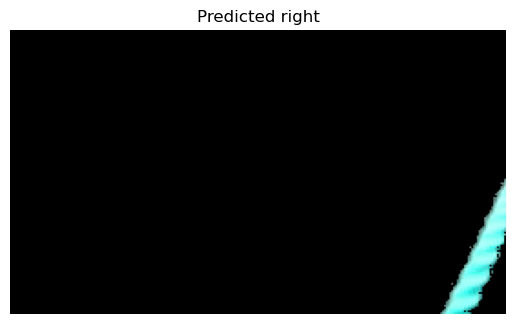

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import shutil


file_path = 'images/.ipynb_checkpoints'

if os.path.exists(file_path):
    shutil.rmtree(file_path)
    print("File deleted successfully.")
else:
    print("File not found.")



%pip install scikit-learn
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets, models
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from PIL import Image


# Custom Dataset for loading images
class LineDirectionDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Data Preprocessing & Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

# Assuming the dataset is located in the directories: images/forward, images/left, images/right
image_dir = 'images'
categories = ['forward', 'left', 'right']

image_paths = []
labels = []

for idx, category in enumerate(categories):
    category_path = os.path.join(image_dir, category)
    for filename in os.listdir(category_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_paths.append(os.path.join(category_path, filename))
            labels.append(idx)  # 0=forward, 1=left, 2=right

# Train-Test Split
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.33
                                                                      , random_state=42)

train_dataset = LineDirectionDataset(train_paths, train_labels, transform=transform)
test_dataset = LineDirectionDataset(test_paths, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define a simple CNN model (you can modify this as necessary)
class LineDirectionCNN(nn.Module):
    def __init__(self):
        super(LineDirectionCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 112 * 112, 128)
        self.fc2 = nn.Linear(128, 3)  # 3 output classes (forward, left, right)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(-1, 64 * 112 * 112)  # Flatten the image tensor
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model, loss function, and optimizer
model = LineDirectionCNN()

# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the selected device
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0015)

# Training Loop
num_epochs = 15

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in train_loader:
        # Move inputs and labels to the selected device (GPU or CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {correct_predictions/total_predictions:.4f}')

# Testing Loop
model.eval()
correct_predictions = 0
total_predictions = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        # Move inputs and labels to the selected device (GPU or CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

print(f'Test Accuracy: {correct_predictions/total_predictions:.4f}')


import matplotlib.pyplot as plt
from PIL import Image

def visualize_and_predict(model, image_path, transform):
    # Load the image and apply transformation
    image = Image.open(image_path)
    image_tensor = transform(image).unsqueeze(0)

    # Move image tensor to the same device as the model
    image_tensor = image_tensor.to(device)

    model.eval()
    
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_class = torch.max(output, 1)
    
    classes = ['forward', 'left', 'right']
    model_save_path = "follower.pth"

# Save the model's state_dict (weights)
    torch.save(model.state_dict(), model_save_path)
    predicted_label = classes[predicted_class.item()]

    plt.imshow(image)
    plt.title(f"Predicted {predicted_label}")

    plt.axis("off")
    plt.show()

# Test the function with a sample image
test_image_path = "images/right/right_318.png"  # Replace this with a valid image path
visualize_and_predict(model, test_image_path, transform)